### Import part

In [1]:
import glob
import unicodedata
import string
import codecs 
import torch
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

##  Classification Using Character-Level Recurrent Neural Networks

### Preparing Data

In [13]:
all_train_filenames = glob.glob('train/*.txt')
all_val_filenames = glob.glob('val/*.txt')
print(all_train_filenames)
print(all_val_filenames)

['train/in.txt', 'train/pk.txt', 'train/fr.txt', 'train/af.txt', 'train/cn.txt', 'train/za.txt', 'train/fi.txt', 'train/ir.txt', 'train/de.txt']
['val/in.txt', 'val/pk.txt', 'val/fr.txt', 'val/af.txt', 'val/cn.txt', 'val/za.txt', 'val/fi.txt', 'val/ir.txt', 'val/de.txt']


In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [14]:
# Build the category_lines dictionary, a list of names per language
category_lines_train = {}
category_lines_val = {}
all_train_categories = []
all_val_categories = []


# Read a file and split into lines
def readLines(filename):
    ascii_vocab = list()
    lines = codecs.open(filename,"r",encoding="utf-8",errors='ignore').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_train_filenames:
    print(filename)
    category = filename.split('/')[-1].split('.')[0]
    all_train_categories.append(category)
    lines = readLines(filename)
    category_lines_train[category] = lines

n_categories = len(all_train_categories)
print('n_categories =', n_categories)
for filename in all_val_filenames:
    print(filename)
    category = filename.split('/')[-1].split('.')[0]
    all_val_categories.append(category)
    lines = readLines(filename)
    category_lines_val[category] = lines
n_categories_val = len(all_val_categories)
print('n_categories_val =', n_categories_val)

train/in.txt
train/pk.txt
train/fr.txt
train/af.txt
train/cn.txt
train/za.txt
train/fi.txt
train/ir.txt
train/de.txt
n_categories = 9
val/in.txt
val/pk.txt
val/fr.txt
val/af.txt
val/cn.txt
val/za.txt
val/fi.txt
val/ir.txt
val/de.txt
n_categories_val = 9


### Names to tensors

In [5]:
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

### Creating the Network

In [6]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

### Manually testing the network

In [7]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)


### Preparing for Training

In [8]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

In [19]:
def random_training_pair(all_categories,category_lines):                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair(all_val_categories,category_lines_val)
    print('category =', category, '/ line =', line)

category = fi / line = wingfield estate
category = ir / line = dobalootan morgha
category = cn / line = wangjiawei
category = fi / line = marby
category = ir / line = klambir satu
category = fi / line = hatfield peverel
category = de / line = lorenzreuth
category = za / line = dzaglik
category = za / line = zaouia sidi bouzid
category = fr / line = la rochebeaucourt


In [27]:
criterion = nn.NLLLoss() # set up loss function
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [28]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.data

In [25]:
n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair(all_train_categories,category_lines_train)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/Users/weihaoran/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (0m 9s) nan laviole / de ✗ (fr)
10000 10% (0m 18s) nan peabiru / de ✗ (ir)
15000 15% (0m 28s) nan galupadeh / de ✓
20000 20% (0m 37s) nan sarteb baba khel / de ✗ (af)
25000 25% (0m 46s) nan ndessa / de ✓
30000 30% (0m 55s) nan jariabad / de ✗ (ir)
35000 35% (1m 4s) nan haji husain hingoro / de ✗ (pk)
40000 40% (1m 14s) nan rochoubras / de ✗ (fr)
45000 45% (1m 24s) nan fitore / de ✗ (fi)


KeyboardInterrupt: 

### Result Plotting

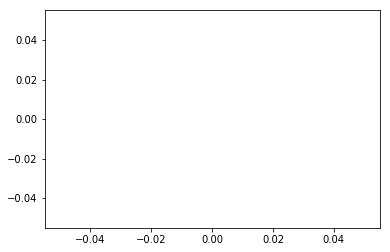

In [26]:
plt.figure()
plt.plot(all_losses)

### Evaluating the result

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()